#Time-Series Visualize Intermediate Representations
ts_visualize_ir.ipynb

This notebook allows for data exploration using the intermediate representation formats (IR1 dataframes, IR2 and final numpy arrays) defined in the LLVM inspired architecure of the load_data_time_series work.

Author:  [Lee B. Hinkle](https://userweb.cs.txstate.edu/~lbh31/), [IMICS Lab](https://imics.wp.txstate.edu/), Texas State University, 2023

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

TODO:
* Need to handle multi-label case (see PSG-Audio)
* Need to correct PSG-Audio dtypes in the loader and remove code here.



In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt # for plotting training curves
#imports for computing and displaying output metrics
from tabulate import tabulate # for verbose tables, showing data
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import urllib.request # to get files from web w/o !wget

# Get Transform (xform) functions to help with plotting

In [2]:
def get_py_file(fname, url):
    """checks for local file, if none downloads from URL.    
    :return: nothing"""
    if (os.path.exists(fname)):
        print ("Local",fname, "found, skipping download")
    else:
        print("Downloading",fname, "from IMICS git repo")
        urllib.request.urlretrieve(url, filename=fname)

In [3]:
try:
    import load_data_transforms as xform
except:
    get_py_file(fname = 'load_data_transforms.py', url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/load_data_transforms.py')
    import load_data_transforms as xform
    
# At this time utils aren't needed, leaving here just in case
# get_py_file(fname = 'load_data_utils.py', url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/load_data_utils.py')
# import load_data_utils as utils

In [12]:
#@title Select Dataset
dataset = "TWristAR Free-Form" #@param ["TWristAR","TWristAR Free-Form","Gesture Phase Segmentation","PSG-Audio"]

# Get the dataset loaders to grab a dictionary of IR1 formatted data

In [13]:
if dataset == "TWristAR":
    try:
        import twristar_load_dataset as twristar
    except:
        get_py_file(fname = 'twristar_load_dataset.py', url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/HAR/TWristAR/twristar_load_dataset.py')
        import twristar_load_dataset as twristar
    twristar.scripted = True # set back to default if unscripted previously run
    ir1_dict = twristar.get_twristar_ir1_dict()
    label_dict = twristar.label_map_twristar['label']
elif dataset == "TWristAR Free-Form":
    try:
        import twristar_load_dataset as twristar
    except:
        get_py_file(fname = 'twristar_load_dataset.py', url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/HAR/TWristAR/twristar_load_dataset.py')
        import twristar_load_dataset as twristar
    twristar.scripted = False
    ir1_dict = twristar.get_twristar_ir1_dict()
    label_dict = twristar.label_map_twristar['label']
elif dataset == "Gesture Phase Segmentation":
    try:
        import gesture_phase_segmentation_load_dataset as gps
    except:
        get_py_file(fname = 'gesture_phase_segmentation_load_dataset.py', url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/Gesturing_Signing/gesture_phase_segmentation_load_dataset.py')
        import gesture_phase_segmentation_load_dataset as gps
    ir1_dict = gps.get_gps_ir1_dict()
    label_dict = gps.label_map_gps['label']
elif dataset == "PSG-Audio":
    # PSG-Audio is so big, that for now I'm just grabbing one IR1.
    #https://drive.google.com/file/d/1-XG6h3N_QgAlAfKyP1d8CQ0x8UChIoJh/view?usp=sharing
    !gdown "1-XG6h3N_QgAlAfKyP1d8CQ0x8UChIoJh&confirm=t" # PSG-Audio IR1 Sub 995
    psg_df = pd.read_pickle("./995_ir1_df.pkl")
    # this code originally pulled from latest TWRistAR loader
    # Select columns with 'float64' dtype  
    float64_cols = list(psg_df.select_dtypes(include='float64'))
    # This gives a key length error?
    # psg_df[float64_cols] = psg_df[float64_cols].astype('float32')
    # But this loop seems to work?
    for i in float64_cols:
        #print(i)
        psg_df[i] = psg_df[i].astype('float32')
    # Explicitly type the label columns to category.
    psg_df['Cardiac']=psg_df['Cardiac'].astype('category')
    psg_df['Limb']=psg_df['Limb'].astype('category')
    psg_df['Nasal']=psg_df['Nasal'].astype('category')
    psg_df['Neuro']=psg_df['Neuro'].astype('category')
    psg_df['Respiratory']=psg_df['Respiratory'].astype('category')
    psg_df['SpO2']=psg_df['SpO2'].astype('category')
    # just grab a few minutes - plotting a full session takes ~10min in colab
    print("Grabbing a slice of PSG-Audio data, plotting a full night session takes ~10min in colab")
    print("Original Start Time", psg_df.index[0])
    print("Original End Time  ", psg_df.index[-1])
    psg_df = psg_df.loc['2019-04-17 22:40:00':'2019-04-17 22:41:00']
    ir1_dict = {'995_ir1_df': psg_df}
    # TODO Labels are listed in the PSG downloader.
    #label_dict = gps.label_map_gps['label']
else:
    print("Error",dataset,"not found")
key_list = list(ir1_dict) # ir1_dict.keys() returns a dict_keys type
my_key = 0 # sort of a global

Local load_data_transforms.py found, skipping download
Unzipping TWristAR file in . directory


# Running the next cell will cycle through all of the IR1 dataframes in the dataset

Dataset:  TWristAR Free-Form Source file: 1574625540_A01F11
Start Time 2019-11-24 19:59:00
 End Time  2019-11-24 20:10:59.750000128
{'Downstairs': 0, 'Jogging': 1, 'Sitting': 2, 'Standing': 3, 'Upstairs': 4, 'Walking': 5, 'Undefined': 99}
Walking       14752
Sitting        2656
Upstairs       2017
Undefined      1843
Downstairs     1536
Standing        128
Jogging          97
Name: label, dtype: int64
None


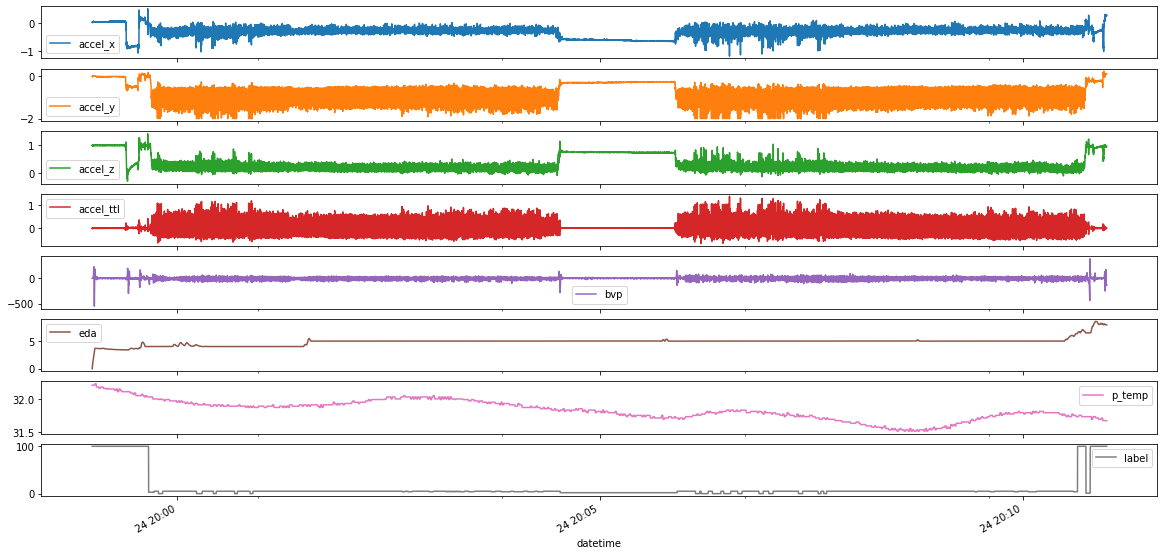

In [14]:
print("Dataset: ", dataset, "Source file:",key_list[my_key])
my_df = ir1_dict[key_list[my_key]]
print("Start Time", my_df.index[0])
print(" End Time ", my_df.index[-1])
if not dataset=='PSG-Audio':  # not setup to handle multi-label yet
    print(label_dict)
    print("Samples for each class (not")
    print(print (my_df['label'].value_counts()))
    # convert dataframe categorical strings to ints per label mapping dict (so they can be plotted and take less room)
    my_df = xform.assign_ints_ir1_labels(my_df, label_mapping_dict = label_dict)
my_df.plot(subplots=True, figsize=(20, 10))
my_key = (my_key + 1) % len(key_list)

# should be able to control output further as pandas generates matplotlib obj
# https://pandas.pydata.org/docs/getting_started/intro_tutorials/04_plotting.html

# Get the full numpy arrays - this needs updates!
Be careful of inspecting the test arrays!   The last version of this notebook in the internal repo has lot more per subject code from when IR3 contained both train and test data.  This was changed because it could result in leakage for more complex datasets that need further processing such as rebalancing training class.

In [ ]:
all_channels = ['accel_x', 'accel_y', 'accel_z', 'accel_ttl', 'bvp', 'eda', 'p_temp']
# TODO:  above should be pulled from dataframe column names
keep_channels = ['accel_x', 'accel_y', 'accel_z', 'accel_ttl']
x_train, y_train, x_test, y_test \
                            = loader.twristar_load_dataset(
                                one_hot_encode = False,
                                keep_channel_list = keep_channels)
headers = ("Array","shape", "data type")
mydata = [("x_train:", x_train.shape, x_train.dtype),
        ("y_train:", y_train.shape, y_train.dtype),
        ("x_test:", x_test.shape, x_test.dtype),
        ("y_test:", y_test.shape, y_test.dtype)]
print("\n",tabulate(mydata, headers=headers))
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("\nInstances of each label")
# this should probably be a graph and TWristAR is different in that it uses
# strings for the labels (which take up more space and should be updated)
# when not one-hot encoded.
print("   Label #samples")
print(np.asarray((unique_elements, counts_elements)).T)
print ('\n','-'*72)


 Array     shape          data type
--------  -------------  -----------
x_train:  (2077, 96, 4)  float32
y_train:  (2077, 1)      <U10
x_test:   (1091, 96, 4)  float32
y_test:   (1091, 1)      <U10

Instances of each label
   Label #samples
[['Downstairs' '317']
 ['Jogging' '347']
 ['Sitting' '353']
 ['Standing' '342']
 ['Upstairs' '370']
 ['Walking' '348']]

 ------------------------------------------------------------------------


# Plots based on the numpy arrays

In [ ]:
#Find min and max values for consistent plot scales
min_g = np.nanmin(x_train[::1])
max_g = np.nanmax(x_train[::1])
print ('min g value is',min_g,'max g value is',max_g)

min g value is -2.0 max g value is 2.0159488


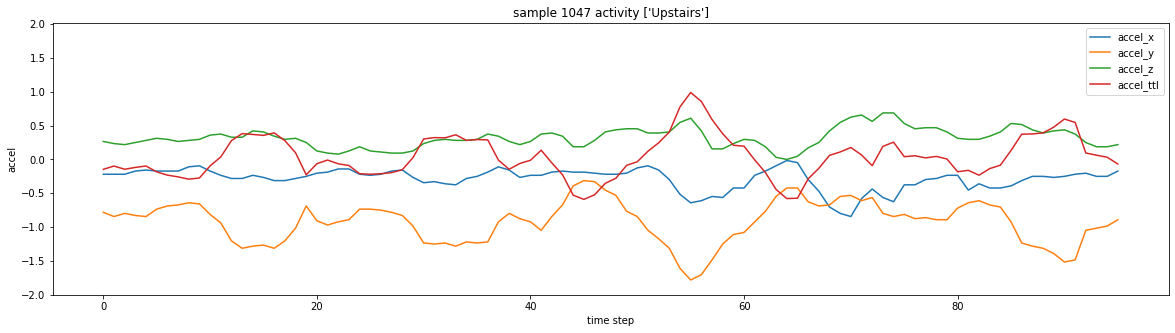

In [ ]:
#@title Select Activity (each cell execution will display a random sample)
Activity_Label = "Upstairs" #@param ['Downstairs','Jogging','Sitting','Standing','Upstairs','Walking']
act_label = Activity_Label
#Plot a random sample - each time cell is run a new one appears
# find index of rows were both sub and activity match
# see https://stackoverflow.com/questions/57496890/numpy-where-matching-two-specific-columns
all_index = np.where(np.all(y_train == act_label, axis=1))
sample_num = np.random.choice(all_index[0], size=1)[0]
plt.figure(figsize=(20,5))
plt.ylim([min_g, max_g])
plt.plot(x_train[sample_num])
plt.title('sample '+str(sample_num)+' activity '+str(y_train[sample_num]))
plt.xlabel("time step")
# Note legend is specific to a version of TWristAR - need to fully implement a
# dictionary with channel names to accomodate all datasets.
plt.ylabel("accel")
plt.legend(['accel_x', 'accel_y', 'accel_z', 'accel_ttl'])
plt.show()

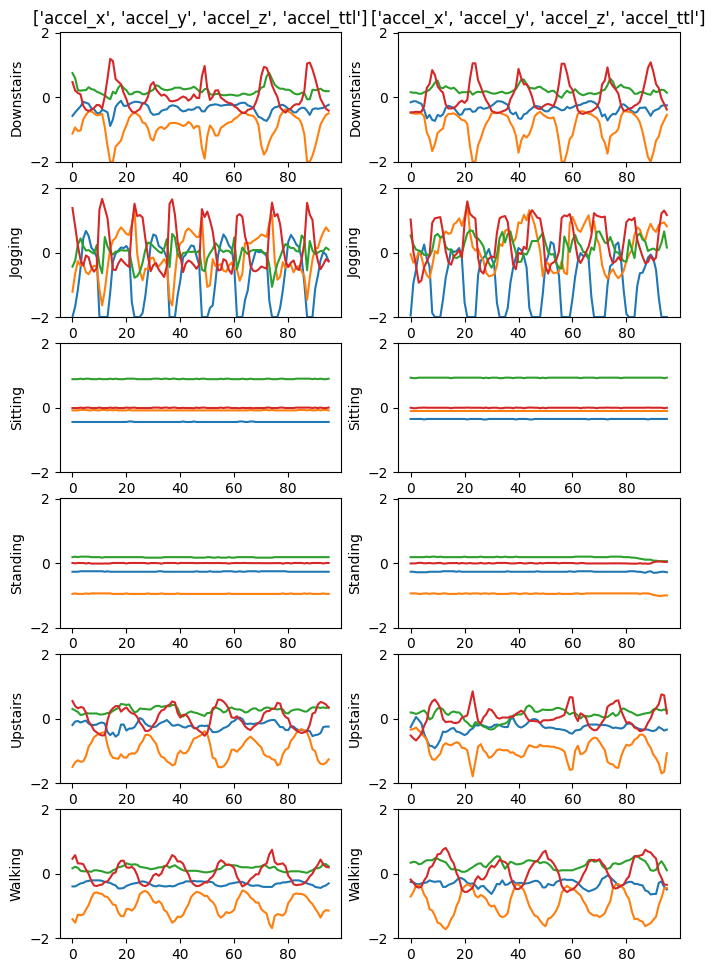

In [ ]:
# Plot two random samples - this time side by side for all activities
l_sub = 1
r_sub = 2
l_idx_list = [] # empty lists to add sample numbers for left and right graphs
r_idx_list = []
unique_labels = np.unique(y_train) # note this works because TWristAR has string lbls
for act_label in unique_labels:
    all_index = np.where(np.all(y_train == act_label, axis=1))
    l_index = np.random.choice(all_index[0], size=1)[0]
    l_idx_list.append(l_index)
    all_index = np.where(np.all(y_train == act_label, axis=1))
    r_index = np.random.choice(all_index[0], size=1)[0]
    r_idx_list.append(r_index)

#all_index = np.where(np.all(y_and_sub[:,0:2] == [act_label, my_sub], axis=1))
#sample_num = np.random.choice(all_index[0], size=1)[0]
# plot side by side - leveraged from final plot in ts_throwdown which is pngs.
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html?highlight=subplots
# spacing needs to be adjusted
# see https://matplotlib.org/stable/tutorials/intermediate/gridspec.html#sphx-glr-tutorials-intermediate-gridspec-py
# see https://matplotlib.org/stable/tutorials/intermediate/tight_layout_guide.html
if (len(l_idx_list) != len(r_idx_list)):
    print("Something went wrong - number of left & right indices aren't equal")
rows = len(l_idx_list)
cols = 2
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize = (8, 12), dpi = 100)
# might want to increase dpi if saving figure; it slows down display time
# I am not proud of the goofy list comprehension, trying to get graphs right!
for r in range(rows):
    for c in range(cols):
        if (r == 0):
            axs[r, c].set_title(keep_channels)
        #axs[r, c].set_axis_off()
        if (c == 0):
            axs[r, c].plot(x_train[l_idx_list[r]])
        else:
            axs[r, c].plot(x_train[r_idx_list[r]])
        axs[r,c].set_ylim(min_g, max_g)
        axs[r,c].set(ylabel=unique_labels[r])
        #axs[r,c].grid(True)